### **01. Blob Detection**

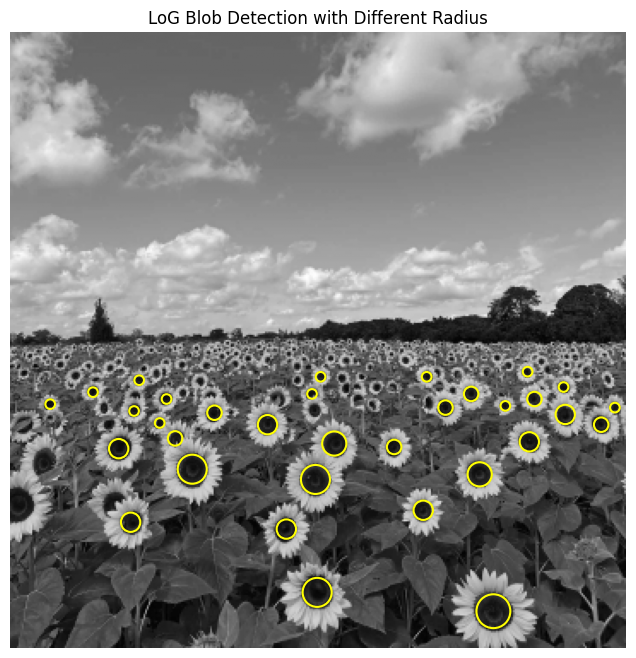

Largest blobs (x, y, radius):
(282, 338, np.float64(9.899494936611665))
(106, 255, np.float64(8.485281374238571))
(178, 261, np.float64(8.485281374238571))
(179, 327, np.float64(8.485281374238571))
(189, 240, np.float64(7.0710678118654755))

Range of σ used: 1.0 to 12.0


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0


sigma_values = np.linspace(1.0, 12.0, 12)   
scale_space = []

#  Build scale space (LoG filtering at multiple scales)
for sigma in sigma_values:
    hw = int(3 * sigma)
    X, Y = np.meshgrid(np.arange(-hw, hw + 1), np.arange(-hw, hw + 1))
    
    LoG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    LoG = (LoG / (np.pi * sigma**4)) * sigma**2   
    
    response = cv.filter2D(gray, cv.CV_32F, LoG)
    response = np.square(response)               
    scale_space.append(response)

scale_space = np.stack(scale_space, axis=-1) 
     
# local maxima detection
blobs = []
threshold = 0.1

for s in range(1, len(sigma_values)-1):
    response = scale_space[:, :, s]
    
    for i in range(1, response.shape[0]-1):
        for j in range(1, response.shape[1]-1):
            
            # 3D neighborhood
            local_cube = scale_space[i-1:i+2, j-1:j+2, s-1:s+2]
            if response[i, j] == np.max(local_cube) and response[i, j] > threshold:
                radius = np.sqrt(2) * sigma_values[s]
                blobs.append((j, i, radius))   

# Draw blobs as circles
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(gray, cmap='gray')

for (x, y, r) in blobs:
    circle = plt.Circle((x, y), r, color='yellow', fill=False, linewidth=1.5)
    ax.add_patch(circle)

plt.title("LoG Blob Detection with Different Radius")
plt.axis('off')
plt.show()

# largest blobs
largest = sorted(blobs, key=lambda b: b[2], reverse=True)[:5]
print("Largest blobs (x, y, radius):")
for b in largest:
    print(b)

print("\nRange of σ used:", sigma_values[0], "to", sigma_values[-1])


### **02. RANSAC**

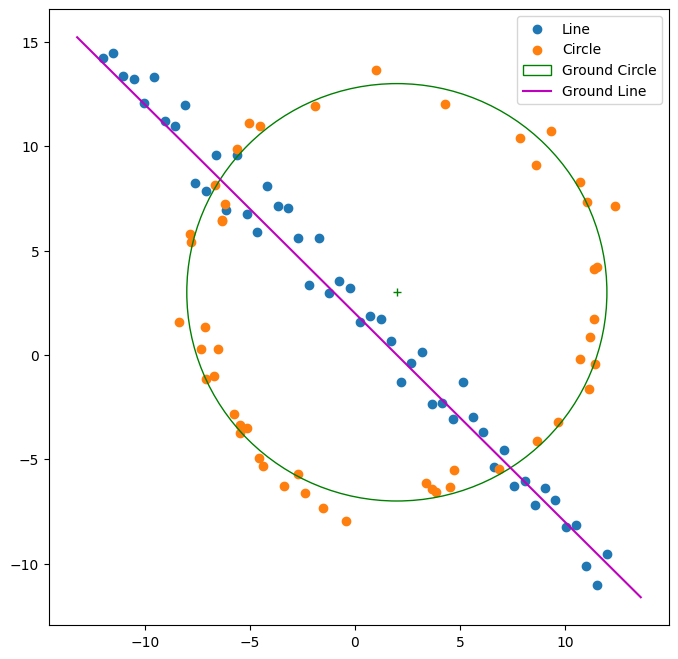

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
ax.plot(x_, y_, color='m', label='Ground Line')

plt.legend()
plt.show()



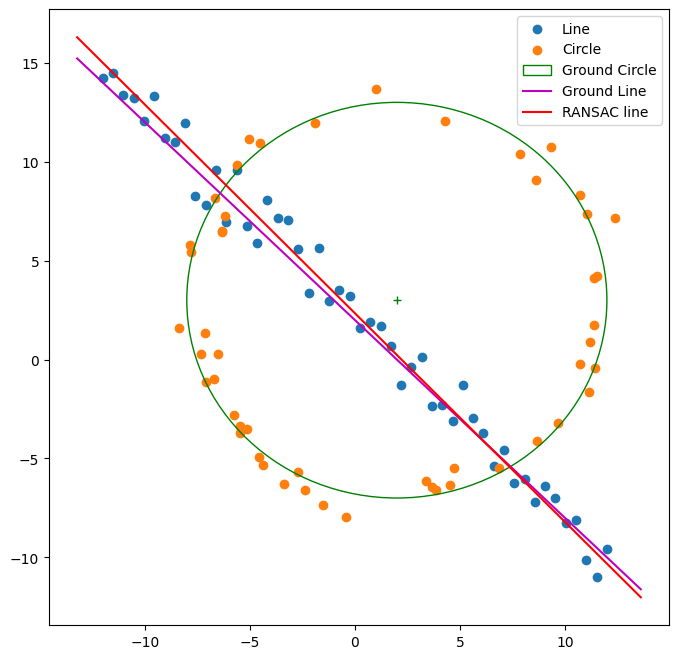

In [4]:
# RANSAC for Line fitting

num_consensus =20
threshold =0.8
iteration = 100
best_param = None
best_inliers = []

for i in range(iteration):
    idx = np.random.choice(len(X),2, replace = False)
    p1, p2 = X[idx]
    
    # vector of p2-p1
    vec = p2-p1
    normal_vec = np.array([-vec[1],vec[0]])
    normal_vec = normal_vec/np.linalg.norm(normal_vec) # ∥[a, b]⊺∥=1
    
    d = np.dot(normal_vec,p1)
    
    distances = np.abs(X @  normal_vec-d)
    
    inliers = np.where(distances<threshold)[0]
    
    if len(inliers)>len(best_inliers) and len(inliers) >= num_consensus:
        best_inliers = inliers
        best_param = np.array([normal_vec[0], normal_vec[1], d])
        

#plot line
best_a, best_b, best_d =best_param

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_fitted = (best_d-best_a*x_)/best_b

ax.plot(x_, y_, color='m', label='Ground Line')
ax.plot(x_, y_fitted, 'r-', label='RANSAC line')


plt.legend()
plt.show()



    
    

In [18]:
# RANSAC dor circle fitting
X_remnant = np.delete(X, best_inliers, axis=0)

iteration_circle = 100
best_param_circle = None
best_circle_inliers = []
num_consensus_circle = 30
threshold_circle =0.6

for i in range(iteration_circle):
    idx_circle = np.random.choice(len(X_remnant),3, replace=False)
    p1, p2, p3 = X_remnant[idx_circle]
    
    
    mat = np.vstack([p2 - p1, p3 - p1])
    if np.linalg.matrix_rank(mat) < 2:
        continue
    
    A = np.array([
        [2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
        [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]
    ])
    
    b = np.array([
        p2[0]**2 + p2[1]**2 - p1[0]**2 - p1[1]**2,
        p3[0]**2 + p3[1]**2 - p1[0]**2 - p1[1]**2
    ])
    center = np.linalg.solve(A, b)
    xc, yc = center
    r = np.sqrt((p1[0]-xc)**2 + (p1[1]-yc)**2)
    
    
    dists = np.sqrt((X_remnant[:, 0] - xc)**2 + (X_remnant[:, 1] - yc)**2)
    radial_error = np.abs(dists - r)

    inliers = np.where(radial_error < threshold_circle)[0]

    if len(inliers) > len(best_circle_inliers) and len(inliers) >= num_consensus_circle:
        best_circle_inliers = inliers
        best_param_circle = np.array([xc, yc, r])
    
    




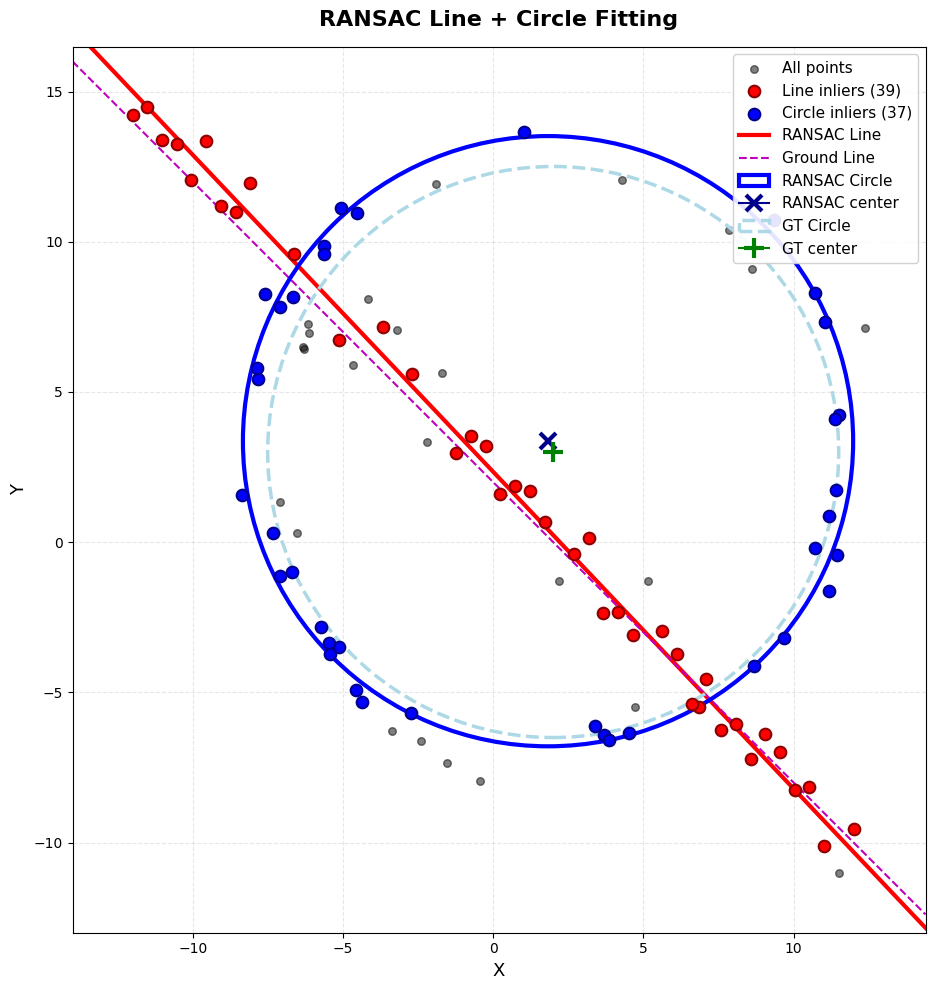


RANSAC Results:

Line Fitting:
  Parameters: a=-0.7258, b=-0.6879, d=-1.6124
  Inliers: 39/100
  Ground truth: m=-1, b=2

Circle Fitting:
  Center: (1.8281, 3.3601)
  Radius: 10.1561
  Inliers: 37/61
  Ground truth: center=(2, 3), radius=9.503678746476332



In [ ]:

fig, ax = plt.subplots(figsize=(10, 10))


padding = 2
x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# ---------------- All points (outliers) ----------------

all_indices = set(range(len(X)))
line_inlier_set = set(best_inliers)

circle_original_indices = set(np.where(np.isin(range(len(X)), 
                                                np.delete(range(len(X)), best_inliers)[best_circle_inliers]))[0])

remnant_indices = np.delete(range(len(X)), best_inliers)
circle_original_indices = set(remnant_indices[best_circle_inliers])

outlier_indices = list(all_indices - line_inlier_set - circle_original_indices)

if len(outlier_indices) > 0:
    ax.scatter(
        X[outlier_indices, 0], X[outlier_indices, 1],
        c='black', s=30, alpha=0.5,
        label='All points', zorder=1
    )

# ---------------- Line inliers ----------------
ax.scatter(
    X[best_inliers, 0], X[best_inliers, 1],
    c='red', s=70, edgecolors='darkred', linewidth=1.5,
    label=f'Line inliers ({len(best_inliers)})', zorder=3
)

# ---------------- Circle inliers ----------------
ax.scatter(
    X_remnant[best_circle_inliers, 0], X_remnant[best_circle_inliers, 1],
    c='blue', s=70, edgecolors='darkblue', linewidth=1.5,
    label=f'Circle inliers ({len(best_circle_inliers)})', zorder=3
)

# ---------------- RANSAC Line ----------------
x_line = np.array([x_min, x_max])
y_fitted = (best_d - best_a * x_line) / best_b
ax.plot(
    x_line, y_fitted,
    color='red', linewidth=3, linestyle='-',
    label='RANSAC Line', zorder=2
)

# ---------------- Ground Truth Line ----------------
m, b = -1, 2
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
ax.plot(x_, y_, color='m', label='Ground Line',linestyle='--')

# ---------------- RANSAC Circle ----------------
if best_param_circle is not None:
    ransac_circle = plt.Circle(
        (best_param_circle[0], best_param_circle[1]),
        best_param_circle[2],
        color='blue', fill=False, linewidth=3,
        label='RANSAC Circle', zorder=2
    )
    ax.add_patch(ransac_circle)
    
    
    ax.plot(
        best_param_circle[0], best_param_circle[1],
        marker='x', markersize=12, mew=3, color='darkblue',
        label='RANSAC center', zorder=4
    )

# ---------------- Ground Truth Circle ----------------
gt_circle = plt.Circle(
    (x0_gt, y0_gt),
    r,
    color='lightblue', fill=False, linewidth=2.5, linestyle='--',
    label='GT Circle', zorder=2
)
ax.add_patch(gt_circle)

ax.plot(
    x0_gt, y0_gt,
    marker='+', markersize=14, mew=3, color='green',
    label='GT center', zorder=4
)

# ---------------- Final Plot  ----------------
ax.legend(fontsize=11, loc='upper right', frameon=True, framealpha=0.9)
ax.set_title("RANSAC Line + Circle Fitting", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("X", fontsize=13)
ax.set_ylabel("Y", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print results
print(f"\n{'='*50}")
print(f"RANSAC Results:")
print(f"{'='*50}")
print(f"\nLine Fitting:")
print(f"  Parameters: a={best_a:.4f}, b={best_b:.4f}, d={best_d:.4f}")
print(f"  Inliers: {len(best_inliers)}/{len(X)}")
print(f"  Ground truth: m={m}, b={b}")

if best_param_circle is not None:
    print(f"\nCircle Fitting:")
    print(f"  Center: ({best_param_circle[0]:.4f}, {best_param_circle[1]:.4f})")
    print(f"  Radius: {best_param_circle[2]:.4f}")
    print(f"  Inliers: {len(best_circle_inliers)}/{len(X_remnant)}")
    print(f"  Ground truth: center=({x0_gt}, {y0_gt}), radius={r}")
print(f"{'='*50}\n")

### **03. Homography transformation**

(np.float64(-0.5), np.float64(1599.5), np.float64(639.5), np.float64(-0.5))

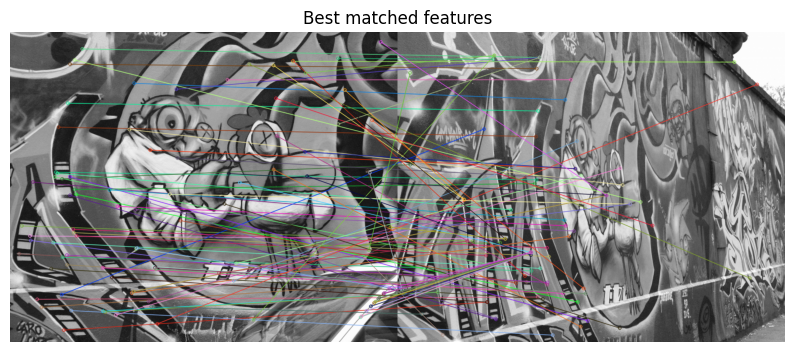

In [23]:
from skimage import transform

def get_sift_features(img1, img2):
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)


    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    
    best_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            best_matches.append(m)

    return best_matches, keypoints1, keypoints2
    
    
img1 = cv.imread("graf/graf/img1.ppm")


img5 = cv.imread("graf/graf/img5.ppm")

best_matches, keypoints1, keypoints5 = get_sift_features(img1, img5)

plt.figure(figsize=(10, 10))
matched_img = cv.drawMatches(cv.cvtColor(img1, cv.COLOR_BGR2GRAY), keypoints1, cv.cvtColor(img5, cv.COLOR_BGR2GRAY), keypoints5, best_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)
plt.title("Best matched features")
plt.axis('off')
